## Getting Dataset from Kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username": "shadyskies",
         "key": "cd89d986353d3eee12678a5d137b3870"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!touch /content/.kaggle/kaggle.json

In [ ]:
f = open("/content/.kaggle/kaggle.json", "r")
print(f.read())
f.close()

{"username": "shadyskies", "key": "cd89d986353d3eee12678a5d137b3870"}


In [ ]:
!echo '{"username":"shadyskies","key":"cd89d986353d3eee12678a5d137b3870"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:34<00:00, 21.4MB/s]
100% 2.29G/2.29G [00:34<00:00, 71.9MB/s]


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                               title                                             size  lastUpdated          downloadCount  
----------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  
gpreda/covid19-tweets                                             COVID19 Tweets                                    21MB  2020-08-14 07:51:12           1968  
christianlillelund/passenger-list-for-the-estonia-ferry-disaster  The Estonia Disaster Passenger List               14KB  2020-07-26 15:40:17            563  
futurecorporation/epitope-prediction                              COVID-19/SARS B-cell Epitope Prediction            1MB  2020-07-24 02:53:28            464  
Cornell-University/arxiv                                          arXiv Dataset                                    877MB  2020-08-14 23:50:57           1341  
claytonmiller/ashrae-global-thermal-comfort-da

In [ ]:
!unzip /content/chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: ches

##Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import numpy as np

##Getting Training Data

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
os.getcwd()

'/content'

In [ ]:
train = get_training_data('/content/chest_xray/train')
test  = get_training_data('/content/chest_xray/test')
val   = get_training_data('/content/chest_xray/val')

Text(0.5, 1.0, 'NORMAL')

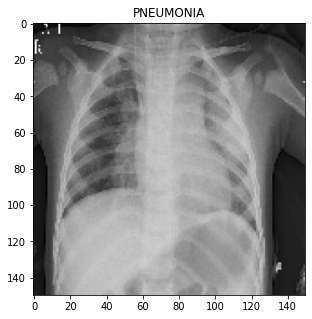

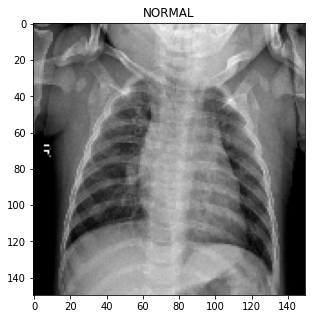

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
x_train = np.array(x_train) / 255
x_test  = np.array(x_test) / 255
x_val   = np.array(x_val) / 255

In [ ]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        )
datagen.fit(x_train)

##Defining model for Classification

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (150,150,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), strides = 2, padding = 'same', activation = 'relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), strides = 2, padding = 'same', activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), strides = 2, padding = 'same', activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 38, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 64)        0

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history1 = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 11s 65ms/step - loss: 0.3275 - accuracy: 0.8625 - val_loss: 3.1617 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 10s 64ms/step - loss: 0.2426 - accuracy: 0.8972 - val_loss: 5.5703 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2118 - accuracy: 0.9132
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 10s 64ms/step - loss: 0.2118 - accuracy: 0.9132 - val_loss: 5.8112 - val_accuracy: 0.5000
Epoch 4/12
163/163 [==============================] - 10s 63ms/step - loss: 0.1769 - accuracy: 0.9306 - val_loss: 5.8500 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 10s 64ms/step - loss: 0.1638 - accuracy: 0.9365 - val_loss: 0.5414 - val_accuracy: 0.6875
Epoch 6/12
163/163 [==============================] - 10s 63ms/step - loss: 0.1486 - accuracy: 0.9392 - val_loss: 1

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 8ms/step - loss: 0.2647 - accuracy: 0.9038
Loss of the model is -  0.2647479772567749
20/20 [==============================] - 0s 8ms/step - loss: 0.2647 - accuracy: 0.9038
Accuracy of the model is -  90.38461446762085 %


##Analysis Graphs

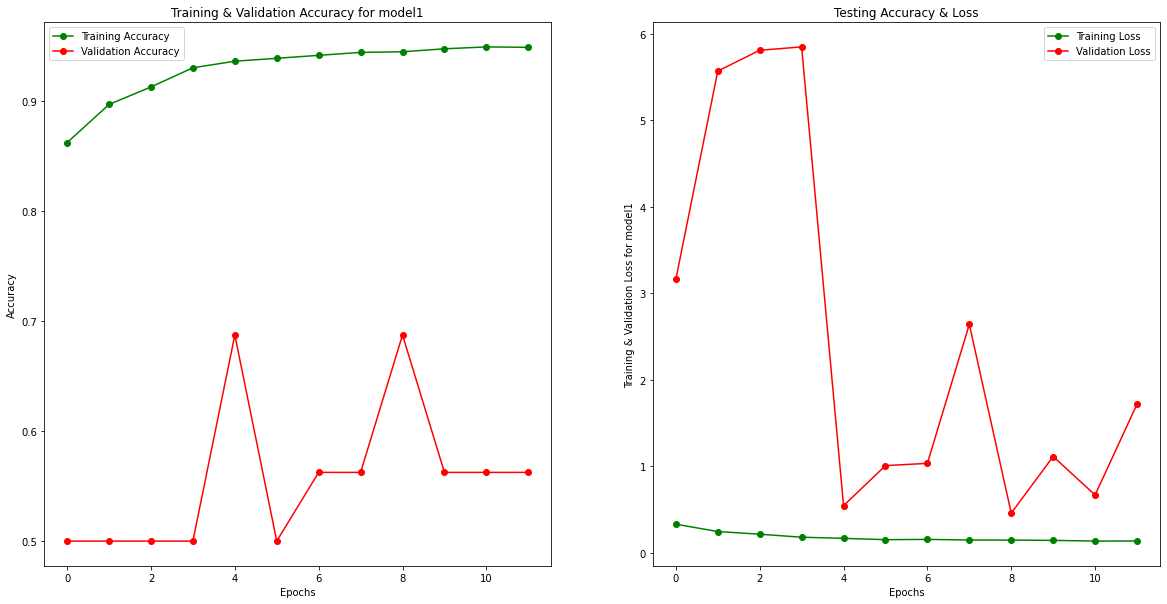

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy for model1')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss for model1")
plt.show()

In [ ]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.95      0.92       390
   Normal (Class 1)       0.91      0.83      0.87       234

           accuracy                           0.90       624
          macro avg       0.90      0.89      0.90       624
       weighted avg       0.90      0.90      0.90       624



In [ ]:
#creating confusion matrix
cm = confusion_matrix(y_test,predictions)
cm

array([[370,  20],
       [ 40, 194]])

In [ ]:
model.save('pn_model1.h5')

##Testing on own images

In [ ]:
img_size = 150
def get_check_im(check_im_dir):
    data = []
    class_num = 2
    for img in os.listdir(check_im_dir):
        try:
            img_arr = cv2.imread(os.path.join(check_im_dir, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            data.append([resized_arr, class_num])
        except Exception as e:
            print(e)
    return np.array(data)

check_im = get_check_im('/content/check_own')

len(check_im)

check_im_test = []
for feature, label in check_im:
    check_im_test.append(feature)

check_im_test = np.array(check_im_test) / 255
check_im_test = check_im_test.reshape(-1, img_size, img_size, 1)

p = model.predict(check_im_test)
p = p.reshape(1,-1)[0]

p

array([0.00021823], dtype=float32)

## Showcasing Convolutions



In [ ]:
import os

In [ ]:
# defining directories
train_pnu_dir = os.path.join("/content/chest_xray/train/PNEUMONIA")
train_nor_dir = os.path.join("/content/chest_xray/train/NORMAL")
test_pnu_dir  = os.path.join("/content/chest_xray/test/PNEUMONIA")
test_nor_dir  = os.path.join("/content/chest_xray/test/NORMAL")

# having a look at filenames
print(os.listdir(train_pnu_dir)[:3])
print(os.listdir(train_nor_dir)[:3])
print(os.listdir(test_pnu_dir)[:3])
print(os.listdir(test_nor_dir)[:3])

['person1016_bacteria_2947.jpeg', 'person1222_virus_2071.jpeg', 'person39_bacteria_198.jpeg']
['NORMAL2-IM-1152-0001-0001.jpeg', 'NORMAL2-IM-0886-0001.jpeg', 'NORMAL2-IM-1130-0001.jpeg']
['person173_bacteria_831.jpeg', 'person93_bacteria_453.jpeg', 'person1628_virus_2822.jpeg']
['NORMAL2-IM-0372-0001.jpeg', 'NORMAL2-IM-0117-0001.jpeg', 'IM-0036-0001.jpeg']


In [ ]:
# Seeing number of images
print("Number of training pneumonic images:", len(os.listdir(train_pnu_dir)))
print("Number of training normal images:", len(os.listdir(train_nor_dir)))
print("Number of test pneumonic images:", len(os.listdir(test_pnu_dir)))
print("Number of test normal images:", len(os.listdir(test_nor_dir)))

Number of training pneumonic images: 3875
Number of training normal images: 1341
Number of test pneumonic images: 390
Number of test normal images: 234


In [ ]:
# having a look at a few images
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#outputting images in 4x4 config
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

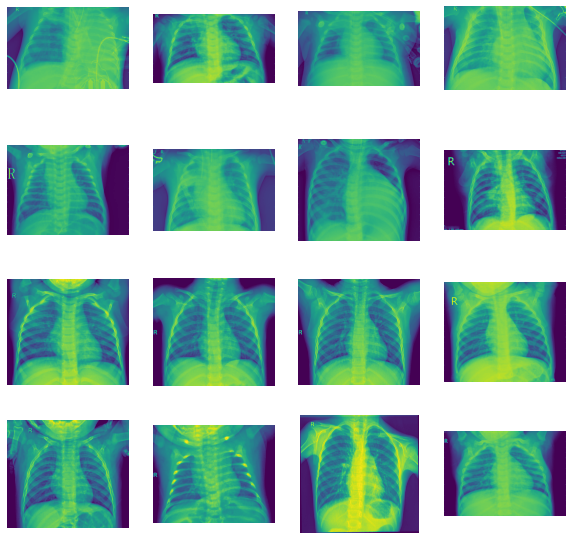

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols * 2.5, nrows * 2.5)

pnu_pics = [os.path.join(train_pnu_dir, fname) for fname in os.listdir(train_pnu_dir)[:8]]
nor_pics = [os.path.join(train_nor_dir, fname) for fname in os.listdir(train_nor_dir)[:8]]

for i, img_path in enumerate(pnu_pics + nor_pics):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines) 
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()